# Multi-Class Classification of RetinaMNIST Dataset with MobileNetV2 Model

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix,classification_report, roc_auc_score


In [4]:
# Import MobleNetV2 (pretrained)
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input


# **Load Data**

In [5]:
#data = np.load('/content/drive/MyDrive/mnist_medical_images/retinamnist.npz')
data = np.load('/data/retinamnist.npz')
print(data.files)  # shows stored arrays like ['images', 'labels']

['train_images', 'val_images', 'test_images', 'train_labels', 'val_labels', 'test_labels']


In [6]:
# Extract arrays
x_train = data['train_images']
y_train = data['train_labels']
x_val   = data['val_images']
y_val   = data['val_labels']
x_test  = data['test_images']
y_test  = data['test_labels']

In [7]:
# check shapes
print("Train:", x_train.shape, y_train.shape)
print("Val:  ", x_val.shape, y_val.shape)
print("Test: ", x_test.shape, y_test.shape)

Train: (1080, 28, 28, 3) (1080, 1)
Val:   (120, 28, 28, 3) (120, 1)
Test:  (400, 28, 28, 3) (400, 1)


# **Data Pre-processing**

In [8]:
#  Resize from 28×28 to 224×224

x_train_resized = tf.image.resize(x_train, [224, 224]).numpy()
x_val_resized   = tf.image.resize(x_val, [224, 224]).numpy()
x_test_resized  = tf.image.resize(x_test, [224, 224]).numpy()


**Apply Class-Balanced Augmentation¶**

In [9]:
# define augmentor

from tensorflow.keras.preprocessing.image import ImageDataGenerator
augmentor = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)


In [10]:
y_train.shape

(1080, 1)

In [11]:
# flatten y
y_train_labels = y_train.flatten()
y_val_labels = y_val.flatten()
y_test_labels = y_test.flatten()

# Find minority classes
unique, counts = np.unique(y_train_labels, return_counts=True)
mean_count = np.mean(counts)
minority_classes = [cls for cls, cnt in zip(unique, counts) if cnt < mean_count]


In [12]:
# Generate augmented samples
augmented_images, augmented_labels = [], []
target_per_class = int(mean_count)


for cls in minority_classes:
    cls_indices = np.where(y_train_labels == cls)[0]
    x_cls = x_train_resized[cls_indices]
    y_cls = y_train_labels[cls_indices]

    gen = augmentor.flow(x_cls, y_cls, batch_size=1)
    for _ in range(target_per_class - len(x_cls)):
        x_aug, y_aug = next(gen)
        augmented_images.append(x_aug[0])
        augmented_labels.append(y_aug[0])

In [13]:
# Combine with original
x_train_balanced = np.concatenate([x_train_resized] + [augmented_images], axis=0)
y_train_balanced = np.concatenate([y_train_labels] + [augmented_labels], axis=0)

In [14]:
from sklearn.utils import shuffle
x_train_balanced, y_train_balanced = shuffle(x_train_balanced, y_train_balanced, random_state=42)

In [15]:
# Preprocess for MobileNetV2, Normalization


x_train_preprocessed = preprocess_input(x_train_balanced)
x_val_preprocessed   = preprocess_input(x_val_resized)
x_test_preprocessed  = preprocess_input(x_test_resized)


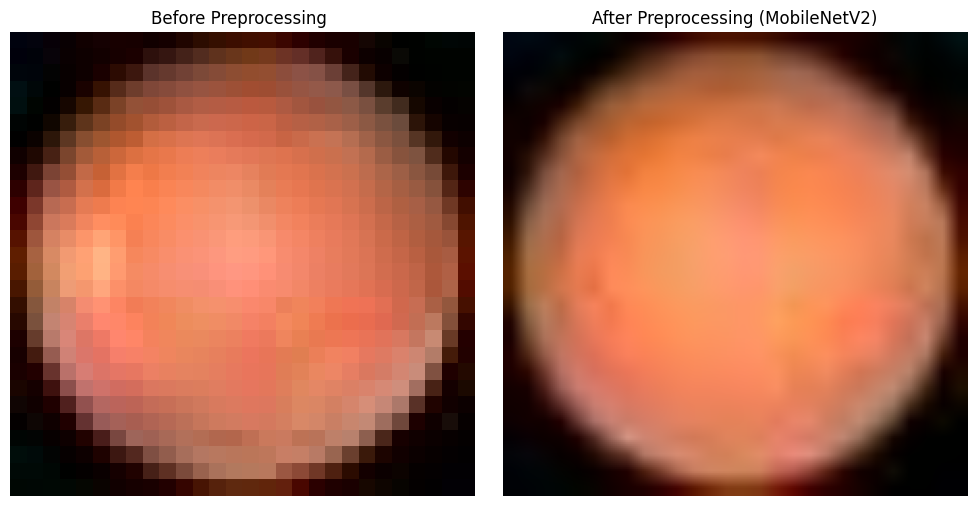

In [16]:
# Visualize samole image before and after pre-processing

# Select a random index
idx = 5  # or any number you like

# Before preprocessing (resized but raw)
original_image = x_train[idx]

# After preprocessing (MobileNetV2)
preprocessed_image = x_train_preprocessed[idx]

# Plot
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Original image
axes[0].imshow((original_image / 255.0))  # Normalize for display
axes[0].set_title("Before Preprocessing ")
axes[0].axis('off')

# Preprocessed image
# Note: Preprocessed values are in [-1, 1], so shift back to [0, 1] for display
axes[1].imshow((preprocessed_image + 1) / 2)
axes[1].set_title("After Preprocessing (MobileNetV2)")
axes[1].axis('off')

plt.tight_layout()
plt.show()


# **Load MobileNetV2 base model**

In [17]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


# **Build Model**

In [18]:
# Freeze the base model
base_model.trainable = False

# Build the full model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')
])

# **Compile Model**

In [19]:
# Compile the Model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Use sparse since labels are integer encoded
    metrics=['accuracy']
)


# **Training**

In [20]:
# Train the Model


early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = model.fit(
    x_train_preprocessed, y_train_balanced,
    validation_data=(x_val_preprocessed, y_val),
    epochs=10,
    batch_size=32,
    callbacks=[early_stop]
)

Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.3049 - loss: 1.7509 - val_accuracy: 0.4167 - val_loss: 1.3711
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.4179 - loss: 1.4292 - val_accuracy: 0.4000 - val_loss: 1.2750
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.4680 - loss: 1.3156 - val_accuracy: 0.4167 - val_loss: 1.2389
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.4903 - loss: 1.2796 - val_accuracy: 0.4750 - val_loss: 1.1754
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.5079 - loss: 1.2435 - val_accuracy: 0.4833 - val_loss: 1.2017
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.4892 - loss: 1.2579 - val_accuracy: 0.4333 - val_loss: 1.1524
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.5059 - loss: 1.2383 - val_accuracy: 0.5250 - val_loss: 1.1367
Epoch 8/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.5078 - loss: 1.1893 - val_accuracy: 0.4917 - val_loss:

# **Evaluation**

In [22]:
# Evaluate
loss, acc = model.evaluate(x_test_preprocessed, y_test)
print(f"Loss: {loss}, Accuracy: {acc}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.5130 - loss: 1.2427
Loss: 1.2855454683303833, Accuracy: 0.47749999165534973


In [23]:
y_pred_probs = model.predict(x_test_preprocessed) #Predict probabilities on test set. Returns softmax output for each class


y_pred = np.argmax(y_pred_probs, axis=1)  # Converts softmax probabilities into predicted class labels (integers).
y_true = y_test.flatten() # ensure that the test labels are in the correct 1D shape

13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step


In [24]:
# Classification report
label_names = ['No DR', 'Mild NPDR', 'Moderate NPDR', 'Severe NPDR', 'Proliferative DR']

print(" Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=label_names))

 Classification Report:

                  precision    recall  f1-score   support

           No DR       0.55      0.85      0.67       174
       Mild NPDR       0.17      0.09      0.12        46
   Moderate NPDR       0.38      0.16      0.23        92
     Severe NPDR       0.39      0.28      0.32        68
Proliferative DR       0.25      0.25      0.25        20

        accuracy                           0.48       400
       macro avg       0.35      0.33      0.32       400
    weighted avg       0.43      0.48      0.42       400



In [25]:
# Confusion matrix
print("Confusion Matrix:\n")
print(confusion_matrix(y_true, y_pred))

Confusion Matrix:

[[148   4   9  10   3]
 [ 33   4   4   4   1]
 [ 54   5  15  14   4]
 [ 26   7   9  19   7]
 [  8   3   2   2   5]]


In [28]:
# ROC AUC (macro and micro)
y_true_onehot = to_categorical(y_true, num_classes=5)

auc_macro = roc_auc_score(y_true_onehot, y_pred_probs, average='macro', multi_class='ovr')
auc_micro = roc_auc_score(y_true_onehot, y_pred_probs, average='micro', multi_class='ovr')

print(f"Macro AUC: {auc_macro:.3f}")
print(f"Micro AUC: {auc_micro:.3f}")

Macro AUC: 0.707
Micro AUC: 0.783


# **Fine Tune MobileNetV2**

In [29]:
# Unfreeze the base model
base_model.trainable = True

# Freeze first N layers, unfreeze the rest
for layer in base_model.layers[:-30]:  # Freeze all except the last 30 layers
    layer.trainable = False






In [30]:

from tensorflow.keras.models import clone_model


model_finetuned = clone_model(model)
model_finetuned.build((None, 224, 224, 3))

# compile the model after changing trainable status
model_finetuned.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),  # smaller LR for fine-tuning!
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

# **Training**

In [32]:
# Train the Model


early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = model_finetuned.fit(
    x_train_preprocessed, y_train_balanced,
    validation_data=(x_val_preprocessed, y_val),
    epochs=10,
    batch_size=32,
    callbacks=[early_stop])

Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.2530 - loss: 1.7315 - val_accuracy: 0.2333 - val_loss: 1.6085
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - accuracy: 0.3270 - loss: 1.5983 - val_accuracy: 0.2333 - val_loss: 1.6081
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.3302 - loss: 1.5804 - val_accuracy: 0.2333 - val_loss: 1.6080
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.3073 - loss: 1.5908 - val_accuracy: 0.2333 - val_loss: 1.6082
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.3386 - loss: 1.5702 - val_accuracy: 0.2333 - val_loss: 1.6084


# **Evaluation**

In [33]:
# Evaluate
loss, acc = model.evaluate(x_test_preprocessed, y_test)
print(f"Loss: {loss}, Accuracy: {acc}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.5130 - loss: 1.2427
Loss: 1.2855454683303833, Accuracy: 0.47749999165534973


In [34]:
y_pred_probs = model.predict(x_test_preprocessed) #Predict probabilities on test set. Returns softmax output for each class


y_pred = np.argmax(y_pred_probs, axis=1)  # Converts softmax probabilities into predicted class labels (integers).
y_true = y_test.flatten() # ensure that the test labels are in the correct 1D shape

13/13 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step


In [35]:
# Classification report
label_names = ['No DR', 'Mild NPDR', 'Moderate NPDR', 'Severe NPDR', 'Proliferative DR']

print(" Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=label_names))

 Classification Report:

                  precision    recall  f1-score   support

           No DR       0.55      0.85      0.67       174
       Mild NPDR       0.17      0.09      0.12        46
   Moderate NPDR       0.38      0.16      0.23        92
     Severe NPDR       0.39      0.28      0.32        68
Proliferative DR       0.25      0.25      0.25        20

        accuracy                           0.48       400
       macro avg       0.35      0.33      0.32       400
    weighted avg       0.43      0.48      0.42       400



In [36]:
# Confusion matrix
print("Confusion Matrix:\n")
print(confusion_matrix(y_true, y_pred))

Confusion Matrix:

[[148   4   9  10   3]
 [ 33   4   4   4   1]
 [ 54   5  15  14   4]
 [ 26   7   9  19   7]
 [  8   3   2   2   5]]


In [37]:
# ROC AUC (macro and micro)
y_true_onehot = to_categorical(y_true, num_classes=5)

auc_macro = roc_auc_score(y_true_onehot, y_pred_probs, average='macro', multi_class='ovr')
auc_micro = roc_auc_score(y_true_onehot, y_pred_probs, average='micro', multi_class='ovr')

print(f"Macro AUC: {auc_macro:.3f}")
print(f"Micro AUC: {auc_micro:.3f}")

Macro AUC: 0.707
Micro AUC: 0.783
